In [1]:
"""
auteur:Alexandre
date:2024/09/03

Développement d'un modèle de machine learning pour prédire les résultats du second tour en fonction du premier tour
"""

"\nauteur:Alexandre\ndate:2024/09/03\n\nDéveloppement d'un modèle de machine learning pour prédire les résultats du second tour en fonction du premier tour\n"

# **Modèle de Transfert de Voix**

## Chargement des données

In [2]:
import pandas as pd
import params as prm
import numpy as np
import os

In [3]:
df_1f = pd.read_csv(os.path.join(prm.datasets_path, f"DF_{prm.dataset_1er_tour}.csv"))
df_2f = pd.read_csv(os.path.join(prm.datasets_path, f"DF_{prm.dataset_2nd_tour}.csv"))

## Création du modèle

In [4]:
import torch

In [5]:
class TransfertVoix(torch.nn.Module):
    def __init__(self, N_1er, N_2eme):#, device=None):
        super(TransfertVoix, self).__init__()
        
        self.lin = torch.nn.Linear(N_2eme, N_1er, bias=False)

    def forward(self, p_1):

        M = torch.softmax(self.lin.weight, axis=1)
        p_2_pred = torch.matmul(p_1, M)
        
        return p_2_pred

## Développement d'une fonction de coût spécifique

In [136]:
def pdf_loss(p_pred, p, weight):

    ind_nonzero = (p==0) + (p_pred==0)
    p[ind_nonzero] = 1.
    p_pred[ind_nonzero] = 1.
    kl_div = p * (p.log() - p_pred.log())
    loss_train = (kl_div * weight[:, None]).sum()
    
    return loss_train

## Fonction d'apprentissage

In [137]:
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [151]:
def fit_data(
    df_1f,
    df_2f,
    
    lr=1e-6,
    batch_size=64,
    num_epochs=500,
    
    seed=2022,
    device=None
):
    # Paramètrage des calculs
    if device == "cpu":
        print(f"Il semble y avoir {os.cpu_count()} coeurs dans cet ordi !")
    elif device == "cuda":
        if torch.cuda.is_available() == True:
            print("GPU ! GPU ! GPU !")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda": torch.cuda.empty_cache()

    # Preparation des données
    X_train, X_test, Y_train, Y_test = train_test_split(
        df_1f, df_2f, 
        test_size=.2, 
        random_state=seed, 
        shuffle=True
    )
    loader = DataLoader(
                    TensorDataset(
                        torch.Tensor(X_train.to_numpy()).to(device), 
                        torch.Tensor(Y_train.to_numpy()).to(device)
                    ), batch_size=batch_size, shuffle=True
                )
    sum_sum = torch.Tensor(df_1f.sum(axis=1).to_numpy()).to(device)

    # Préparation du modèle
    N_1er, N_2eme = len(df_1f.columns), len(df_2f.columns)
    trans = TransfertVoix(N_1er, N_2eme)
    trans = trans.to(device)

    # Préparation de l'apprentissage
    optimizer = torch.optim.Adam(
        trans.parameters(), 
        lr=lr
    )

    losses_train = []
    losses_test = []

    for epoch in tqdm(range(int(num_epochs)), desc=f"Computing on {device}"):

        i=0
        
        for p_1, p_2 in loader:

            p_1, p_2 = p_1.to(device), p_2.to(device)
            sum_1, sum_2 = p_1.sum(axis=1), p_2.sum(axis=1)
            
            p_1t = p_1.T / sum_1
            p_2t = p_2.T / sum_2
            
            p_2_pred = trans(p_1)
            weight = sum_2 #/ (sum_sum[p_1.shape[0]*(0+i):p_1.shape[0]*(1+i)] + 1)
            i+=1

            loss_train = pdf_loss(p_2_pred, p_2, weight)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        losses_train.append(loss_train.item())

        with torch.no_grad():
            
            Y_pred = trans(torch.Tensor(X_test.to_numpy()).to(device))
            weight = Y_pred.sum(axis=1)

            losse_test = pdf_loss(Y_pred, torch.Tensor(Y_test.to_numpy()).to(device), weight)
            losses_test.append(losse_test)
            # break

    return trans, np.array(losses_train), np.array(losses_test), Y_pred.cpu().detach().numpy(), Y_test.to_numpy(),

## Entrainement du modèle

In [153]:
num_epoch = 4_000
batch_size = 2**5

In [154]:
trans, losses_train, losses_test, pred, test = fit_data(
    df_1f=df_1f,
    df_2f=df_2f,
    batch_size=batch_size,
    num_epochs=num_epoch,
    device="cpu"
)

Il semble y avoir 16 coeurs dans cet ordi !


Computing on cpu:  39%|███▉      | 1562/4000 [39:47<1:08:58,  1.70s/it]

In [ ]:
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"{len(os.listdir(results_path))}_result")
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), pred)
np.save(os.path.join(result_path, "test"), test)

## Représentation des résultats

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

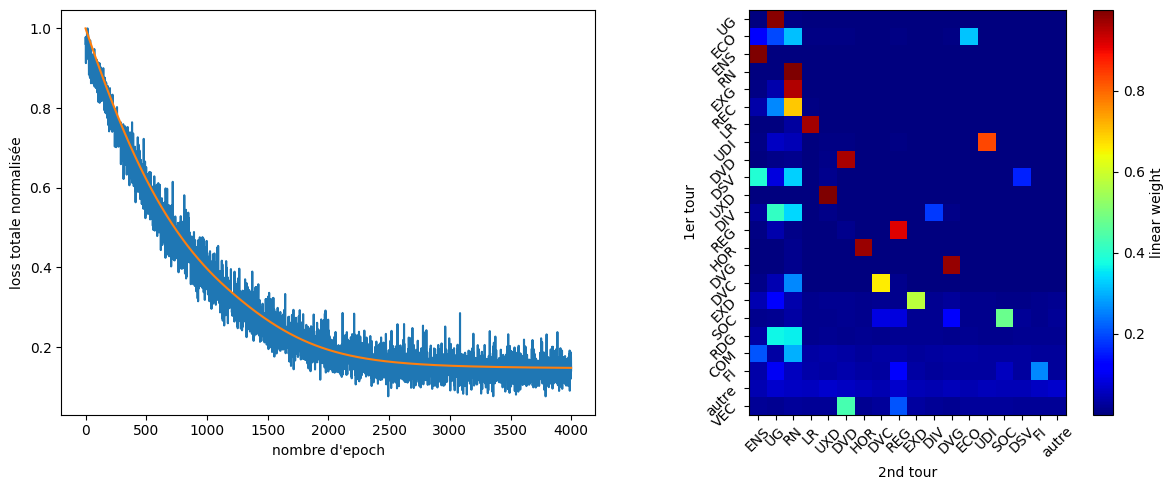

In [148]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12,5),
    dpi=100
)

ax[0].plot(
    range(num_epoch),
    losses_train/losses_train.max()
)
ax[0].plot(
    range(num_epoch),
    losses_test/losses_test.max()
)
ax[0].set_xlabel("nombre d'epoch")
ax[0].set_ylabel("loss totale normalisée")

m1 = ax[1].imshow(
    # trans.lin.weight.cpu().detach().numpy(),
    torch.softmax(trans.lin.weight, axis=1).cpu().detach().numpy(),
    cmap="jet",
    # vmin=-6, vmax=+6
)
cbar = fig.colorbar(m1, ax=ax[1])
cbar.set_label("linear weight")
ax[1].set_xticks(
    range(df_2f.shape[-1]),
    df_2f.keys(),
    rotation=45
)
ax[1].set_yticks(
    range(df_1f.shape[-1]),
    df_1f.keys(),
    rotation=45
)
ax[1].set_xlabel("2nd tour")
ax[1].set_ylabel("1er tour")

plt.tight_layout()
plt.show()

In [149]:
report_norm = (torch.softmax(trans.lin.weight, axis=1).cpu().detach().numpy() / torch.softmax(trans.lin.weight, axis=1).cpu().detach().numpy().max(axis=0))
cmap = prm.cm.tab20

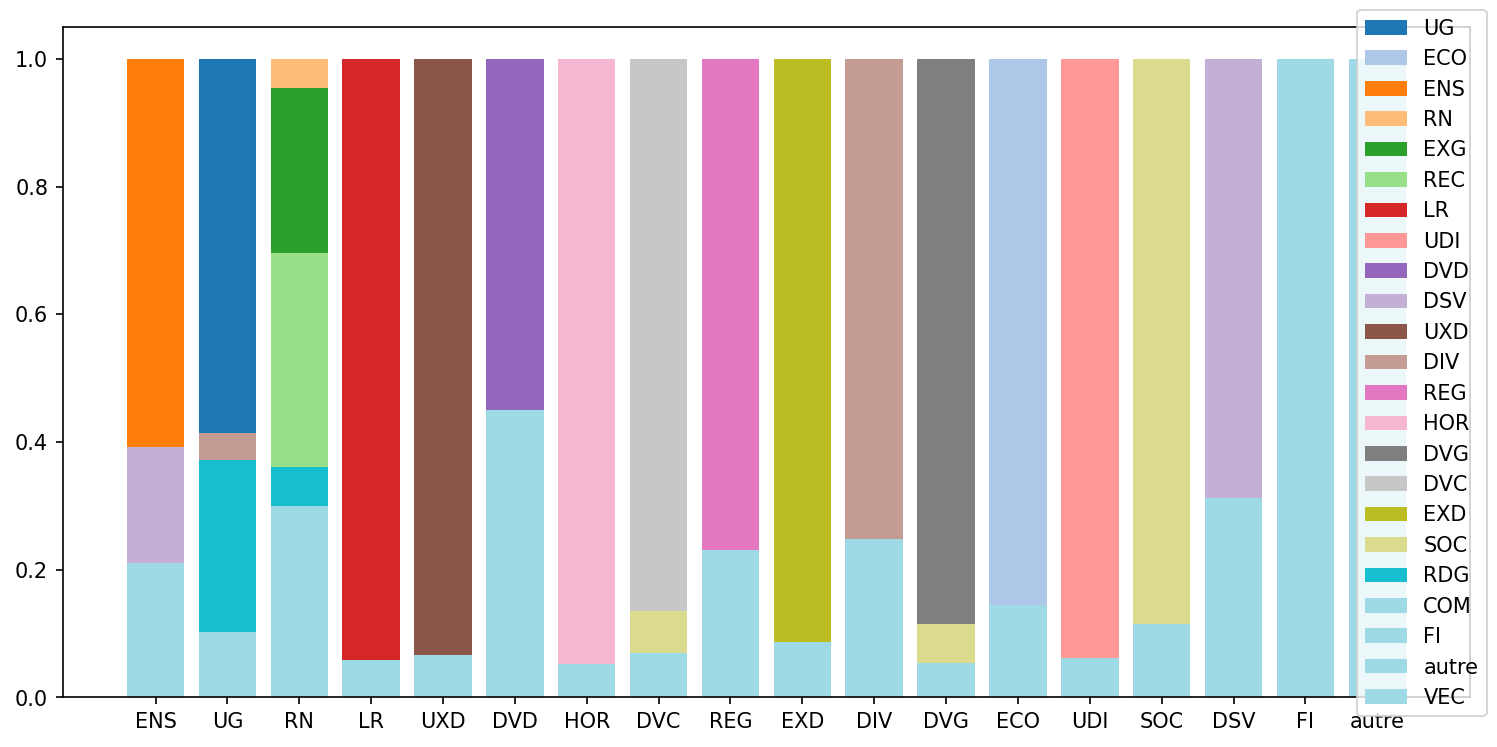

In [150]:
fig,ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(10,5),
    dpi=150
)

for i in range(df_1f.shape[-1]):
    
    b = ax.bar(
        df_2f.keys(),
        height=report_norm[i,:],
        label=df_1f.keys()[i],
        color=cmap(i)
    )

fig.legend()
plt.tight_layout()
plt.show()


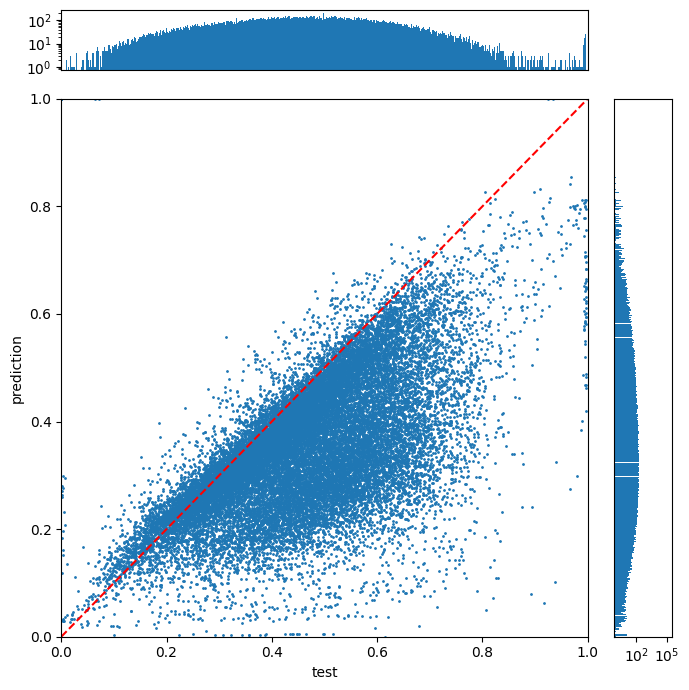

In [14]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(7,7),
    dpi=100,
    gridspec_kw={
        "height_ratios":[0.1,0.9],
        "width_ratios":[0.9,0.1]
                 }
)

values_test, bins_test = np.histogram(test, bins=np.linspace(0.01, test.max(), 500))
ax[0,0].bar(
    x=bins_test[:-1],
    height=values_test,
    width=bins_test[1]-bins_test[0]
)
ax[0,0].set_xticks([])
ax[0,0].set_yscale("log")

ax[1,0].scatter(
    x=test.reshape(test.shape[0]*test.shape[-1]),
    y=pred.reshape(pred.shape[0]*pred.shape[-1]),
    s=1
)
ax[1,0].plot(
    [0,1],
    [0,1],
    linestyle="dashed",
    color="red"
)
ax[1,0].set_xlabel("test")
ax[1,0].set_ylabel("prediction")

values_pred, bins_pred = np.histogram(pred, bins=np.linspace(pred.min(), pred.max(), 500))
ax[1,1].barh(
    bins_pred[:-1],
    values_pred,
    height=bins_test[1]-bins_test[0]
)
ax[1,1].set_yticks([])
ax[1,1].set_xscale("log")

ax[0,1].set_axis_off()

ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[0,0].set_xlim(0,1)
ax[1,1].set_ylim(0,1)
plt.tight_layout()
plt.show()


In [15]:
prm.WaTer()

Last updated: 2024-09-04T14:40:31.887613+02:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 116 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

